In [1]:
import jax.numpy as np
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp

import lineax
import jax
import optax
import optimistix

from make_pulse_and_trace import MakePulse, apply_noise

In [2]:
pulse_maker=MakePulse(N=128*12, Deltaf=2) # Deltaf should be 3 for thg and 2 for shg -> depends on central_f is guess, currently 0.5
# ifrog -> Deltaf controls temporal resolution and needs to be sufficiently large 


pulse_maker.multi_pulse_time_domain_length_multiplier=8
pulse_maker.multi_pulse_parameters=[[50, 50], [5, 5, 5], [0.5, 0.25, 0.25], [1, 1, 1], ["flat", "flat", "flat"], [None, None, None]] 

time_inp, pulse_t_inp, frequency_inp, pulse_f_inp=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.35, 0.1], type="polynomial", parameters_phase=[1/4,0,250,0], 
                                                                               multi_pulse_parameters=None)#pulse_maker.multi_pulse_parameters)

input_pulses=pulse_maker.input_pulses





time_gate, pulse_t_gate, frequency_gate, pulse_f_gate=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.45,0.05], type="polynomial", parameters_phase=[2/4,0,0,0], 
                                                                               multi_pulse_parameters=None)

input_pulses_gate=pulse_maker.input_pulses

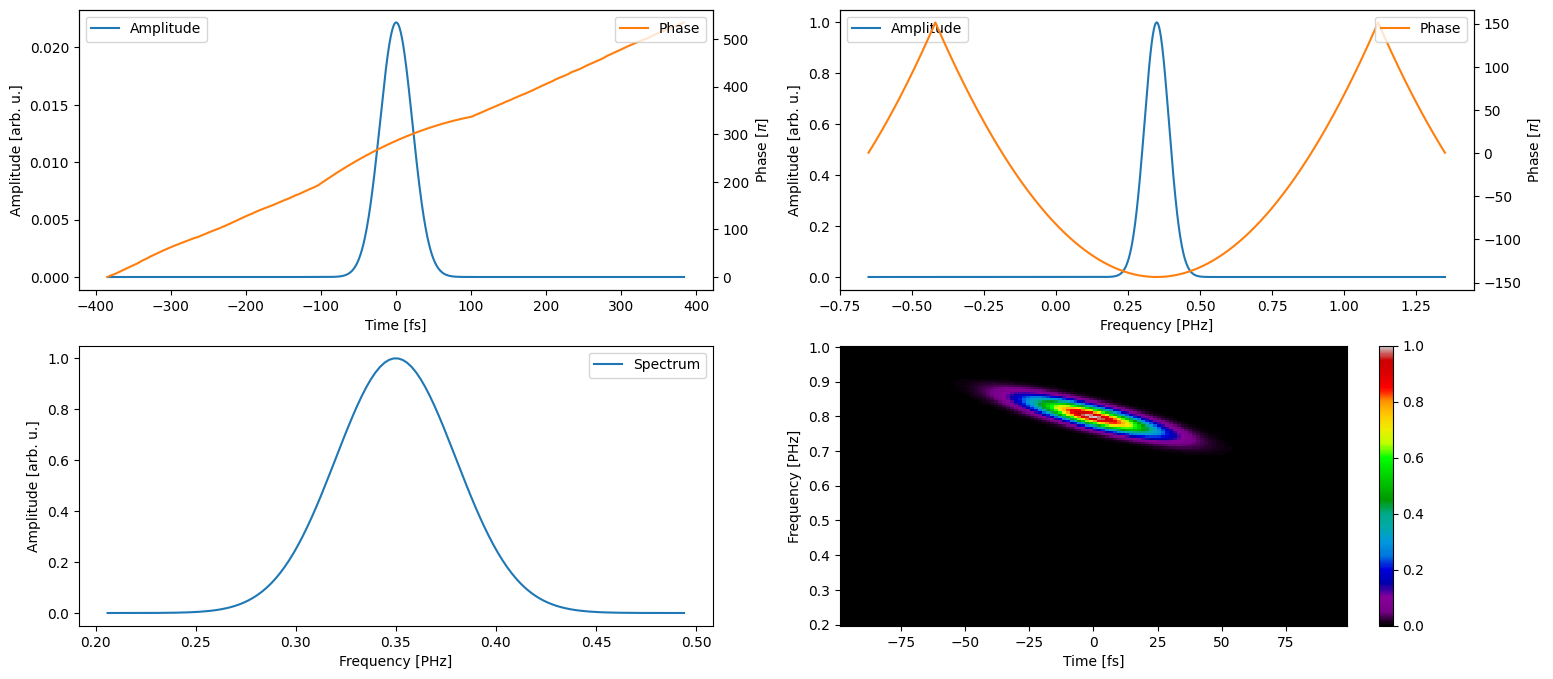

In [3]:
time, frequency, trace, frequency_spectrum, spectrum=pulse_maker.generate_frog_trace_and_spectrum(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, nonlinear_method="shg", 
                                                                                                  scale_time_range=2, N=128, xfrog=True, 
                                                                                                  gate=(frequency_gate, pulse_f_gate),
                                                                                                  interpolate_fft_conform=False, cut_off_val=1e-2,
                                                                                                  ifrog=False, frequency_range=(0.2,1))

#trace = apply_noise(trace, scale_val=(0.05, 0.05), additive_noise=True, multiplicative_noise=True)

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


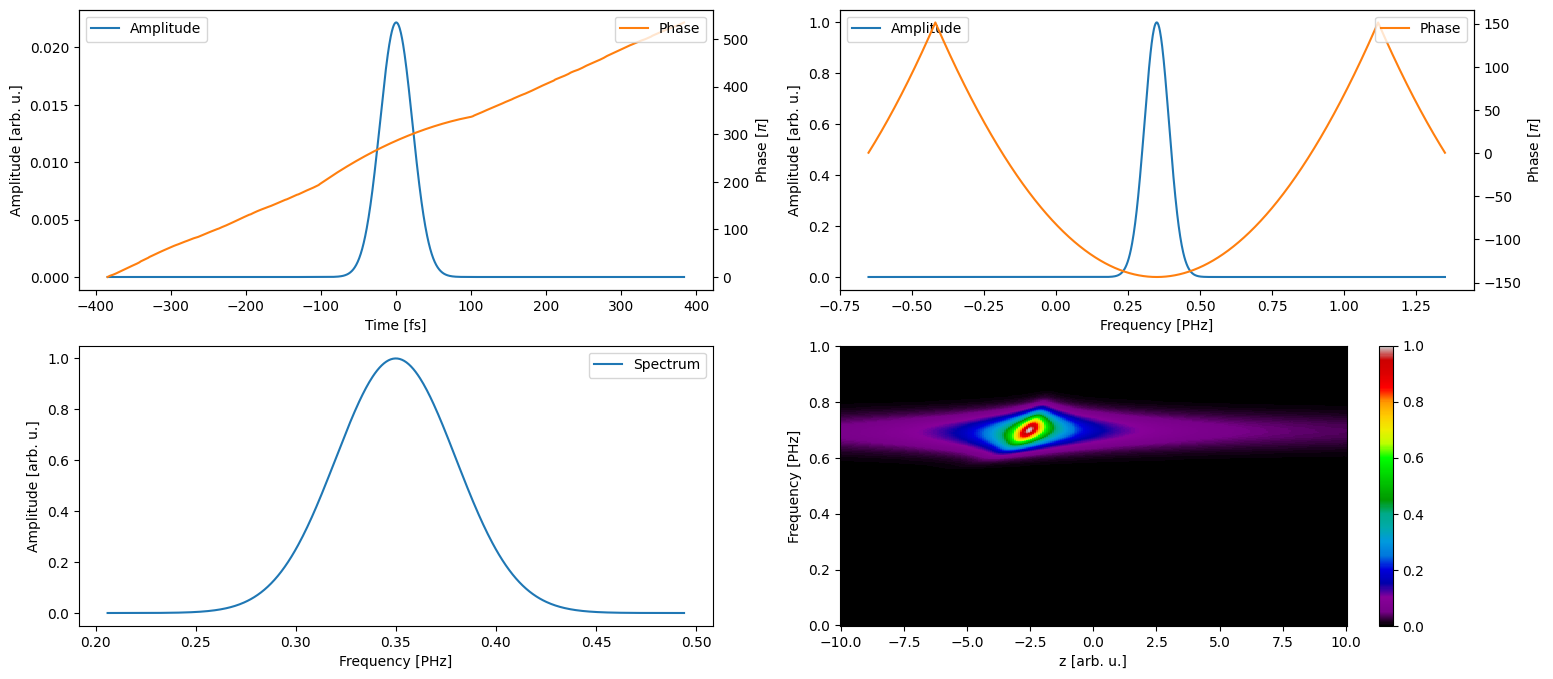

In [4]:
z_arr=np.linspace(-10, 10, 256)
#pulse_t, pulse_f=pulse_maker.precompensate_pulse_for_dscan(time, frequency, pulse_t, GDD=-5000, TOD=0, central_f=0.5)
frequency, trace, frequency_spectrum, spectrum=pulse_maker.generate_dscan_trace_and_spectrum(z_arr, time_inp, frequency_inp, pulse_t_inp, pulse_f_inp,
                                                                                                   nonlinear_method="shg", 
                                                                                                   N=128*4, cut_off_val=1e-4, frequency_range=(0,1))


#trace = apply_noise(trace, scale_val=0.01, additive_noise=True, multiplicative_noise=False)

# if there are weird stripes in the trace -> set Deltaf=2 somehow thats needed

In [4]:
from classic_algorithms_frog import Vanilla, LSGPA, GeneralizedProjection, TimeDomainPtychography, COPRA

refactor this and only generate gate when doubleblind is true
[3.4953582+3.1700106j 0.       +0.j        0.       +0.j
 0.       +0.j        0.       +0.j       ]
[-1.84075-1.2523406j  0.     +0.j         0.     +0.j
  0.     +0.j         0.     +0.j       ]
[-13.967611 -10.618109j    3.4953582 +3.1700106j   0.        +0.j
   0.        +0.j          0.        +0.j       ]
[-0.7722808+2.3385682j -1.84075  -1.2523406j  0.       +0.j
  0.       +0.j         0.       +0.j       ]
[ -4.3951855 -2.1208582j -13.967611 -10.618109j    3.4953582 +3.1700106j
   0.        +0.j          0.        +0.j       ]
[ 1.6011605-0.8196203j -0.7722808+2.3385682j -1.84075  -1.2523406j
  0.       +0.j         0.       +0.j       ]
[ 11.975768  +7.9134803j  -4.3951855 -2.1208582j -13.967611 -10.618109j
   3.4953582 +3.1700106j   0.        +0.j       ]
[ 8.999056 +0.08723581j  1.6011605-0.8196203j  -0.7722808+2.3385682j
 -1.84075  -1.2523406j   0.       +0.j        ]
[ 10.094749  +7.010865j   11.975768  +7.9134

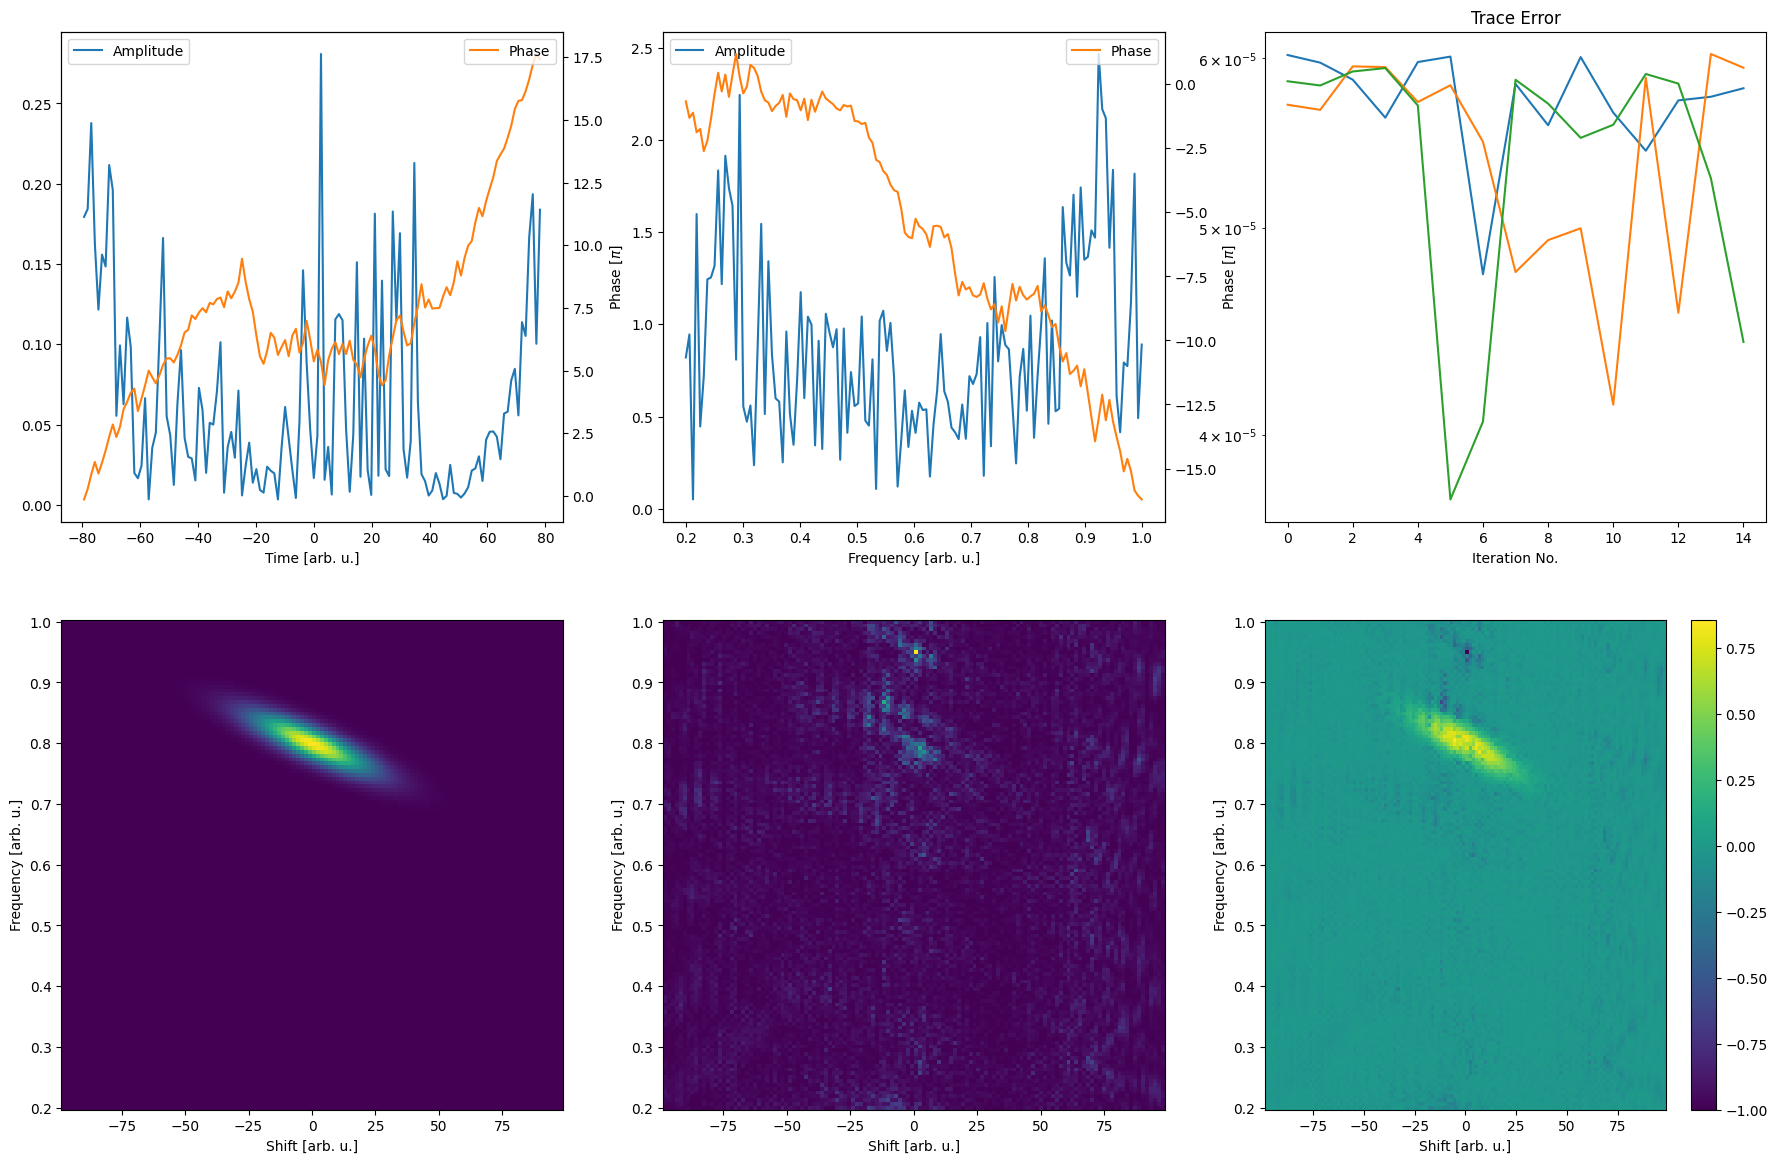

In [5]:
# vanilla = Vanilla(time, frequency, trace, "shg")
# population = vanilla.create_initial_population(population_size=3, guess_type="random")

# final_result = vanilla.run(population, 100)
# vanilla.plot_results(final_result)






# lsgpa = LSGPA(time, frequency, trace, "shg", xfrog="doubleblind")
# population = lsgpa.create_initial_population(population_size=3, guess_type="random")

# lsgpa.lambda_lm = 1e-3
# lsgpa.beta=0.1

# final_result = lsgpa.run(population, 5000)
# lsgpa.plot_results(final_result)






gp = GeneralizedProjection(time, frequency, trace, "shg", xfrog="doubleblind")
population = gp.create_initial_population(population_size=3, guess_type="random")

gp.use_hessian = "lbfgs"

gp.no_steps_gradient_descent=35
gp.max_steps_linesearch=50
gp.gamma=1e2
gp.delta_gamma=0.5
gp.c1=1e-4

gp.lbfgs_memory=5

gp.lambda_lm=1e-3

final_result = gp.run(population, 15)
gp.plot_results(final_result)






# tdp = TimeDomainPtychography(time, frequency, trace, "shg", "ePIE", xfrog="doubleblind")
# population = tdp.create_initial_population(population_size=3, guess_type="random")

# tdp.alpha=1
# tdp.beta=1

# tdp.use_global_step=True
# tdp.use_hessian="diagonal"

# final_result = tdp.run(population, 150)
# tdp.plot_results(final_result)






# copra = COPRA(time, frequency, trace, "shg", xfrog=False)
# population = copra.create_initial_population(population_size=3, guess_type="random")

# copra.use_hessian="diagonal"

# final_result = copra.run(population, 5, 5)
# copra.plot_results(final_result)


In [6]:
from classic_algorithms_dscan import Basic, GeneralizedProjection, TimeDomainPtychography, COPRA

ImportError: cannot import name 'AlgorithmsBase' from 'BaseClasses' (/mnt/c/Users/tillj/Desktop/Frog_zeug_alles/FROG - Pulse Retrieval Algorithms/_All_Algorithms/BaseClasses.py)

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:297: RuntimeWarning: invalid value encountered in divide
  g = lambda c1, c2, w: c1 * (w ** 2) / (w ** 2 - c2 ** 2)
/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


refactor this and only generate gate when doubleblind is true


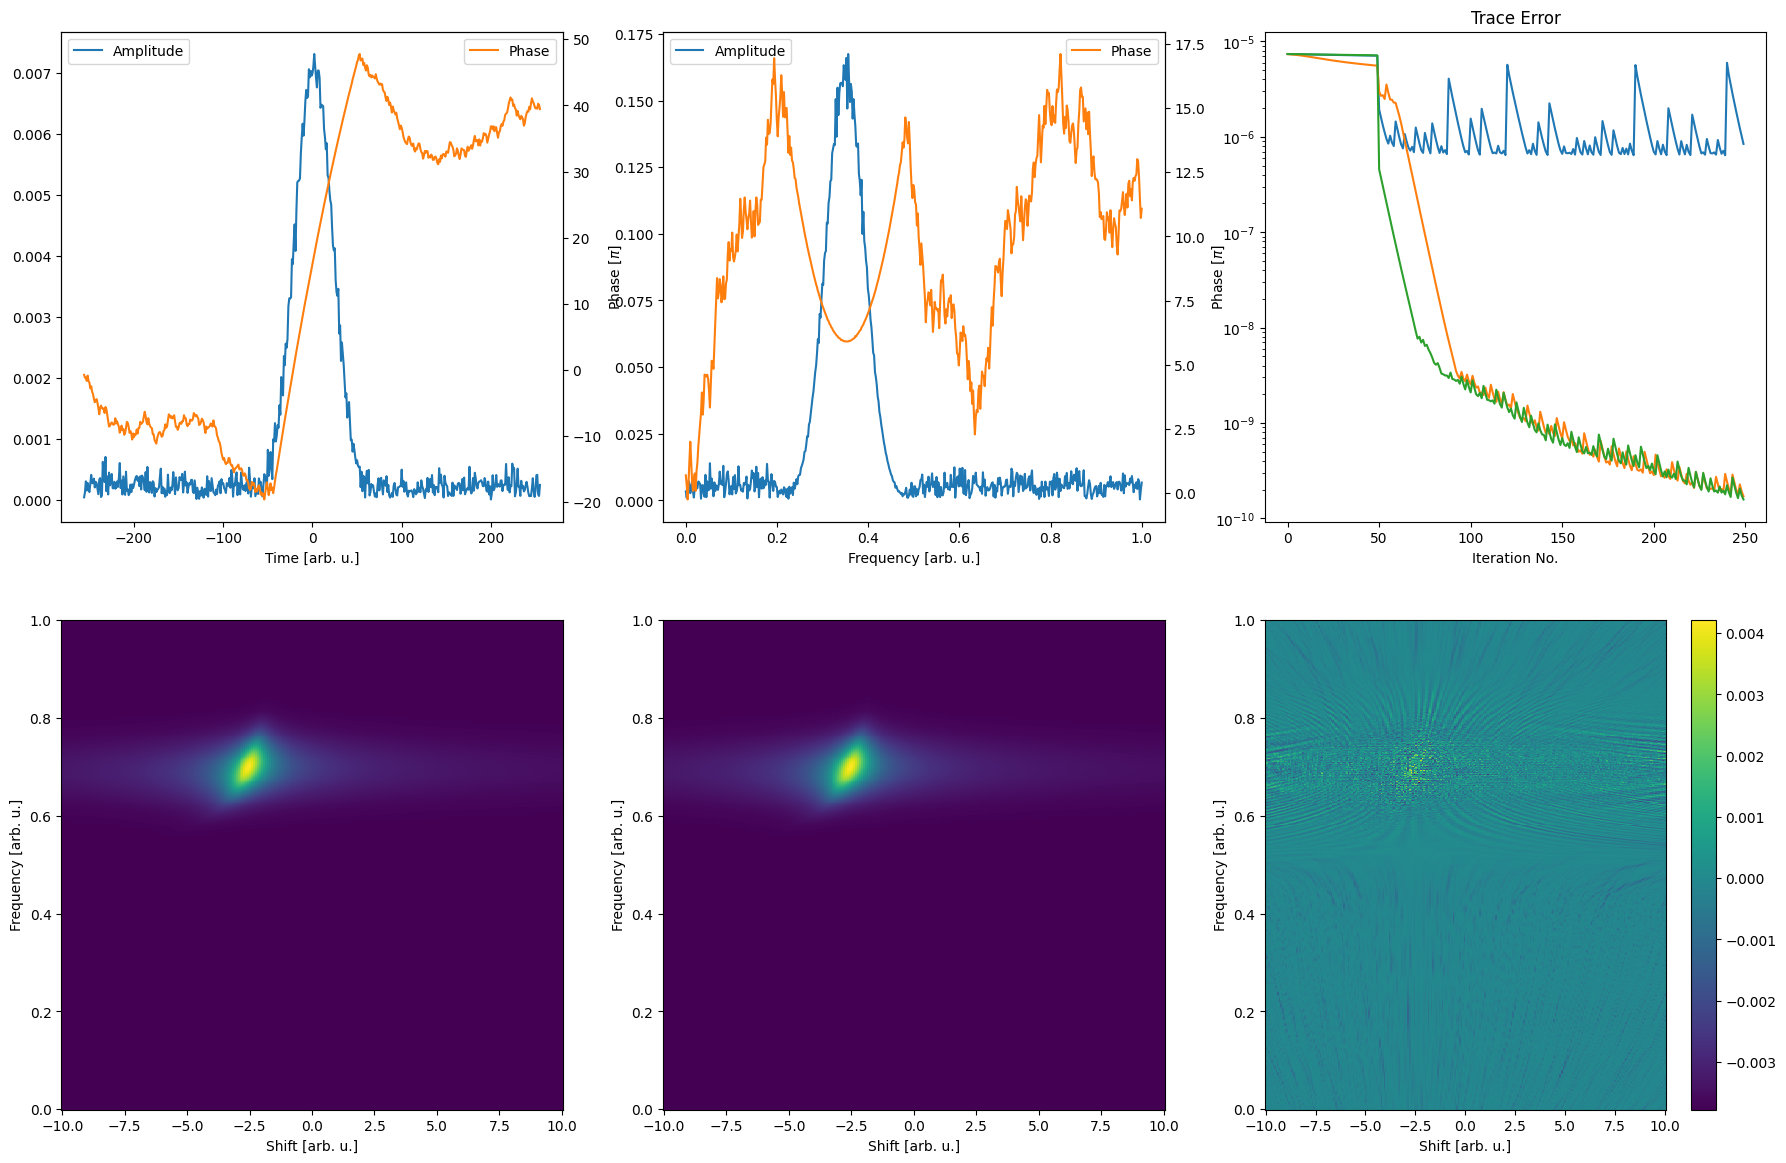

In [ ]:
# basic = Basic(z_arr, frequency, trace, "shg")
# population = basic.create_initial_population(population_size=3, guess_type="random")

# final_result = basic.run(population, 100)
# basic.plot_results(final_result)





# gp = GeneralizedProjection(z_arr, frequency, trace, "shg")
# population = gp.create_initial_population(population_size=3, guess_type="random")

# gp.no_steps_gradient_descent=50
# gp.gamma=1e2

# final_result = gp.run(population, 100)
# gp.plot_results(final_result)




# tdp = TimeDomainPtychography(z_arr, frequency, trace, "shg")
# population = tdp.create_initial_population(population_size=3, guess_type="random")

# final_result = tdp.run(population, 100)
# tdp.plot_results(final_result)






# copra = COPRA(z_arr, frequency, trace, "shg")
# population = copra.create_initial_population(population_size=3, guess_type="random")

# copra.beta = 1e1
# copra.alpha = 1e1
# copra.use_hessian = False, "diagonal"

# final_result = copra.run(population, 50, 200)
# copra.plot_results(final_result)

In [ ]:
from general_algorithms_frog import DifferentialEvolution, Evosax, LSF, AutoGrad

make functions for each type, wait until this subproject seems to be really finalized
population [0.99999994 1.0000001  1.0000001 ]
direction [0.9999999  0.99999994 1.        ]
(Array([[-5.482671],
       [-5.778491],
       [-5.580121]], dtype=float32), Array([[5.054737 ],
       [5.8311067],
       [5.591881 ]], dtype=float32))
(Array([[-6.043004],
       [-5.756646],
       [-7.045478]], dtype=float32), Array([[6.4739437],
       [4.440029 ],
       [6.793082 ]], dtype=float32))
population [1.000122  0.9888742 6.191513 ]
direction [1.         0.99999994 1.        ]
(Array([[-7.6833405],
       [-3.0210655],
       [-2.5651236]], dtype=float32), Array([[7.4865618e+00],
       [1.4305115e-06],
       [9.5367432e-07]], dtype=float32))
(Array([[-4.449868 ],
       [-5.7887287],
       [-0.8085289]], dtype=float32), Array([[5.830394 ],
       [5.975803 ],
       [1.1146793]], dtype=float32))
population [0.99986327 5.8536425  6.002154  ]
direction [1.         1.         0.99999994]
(Array

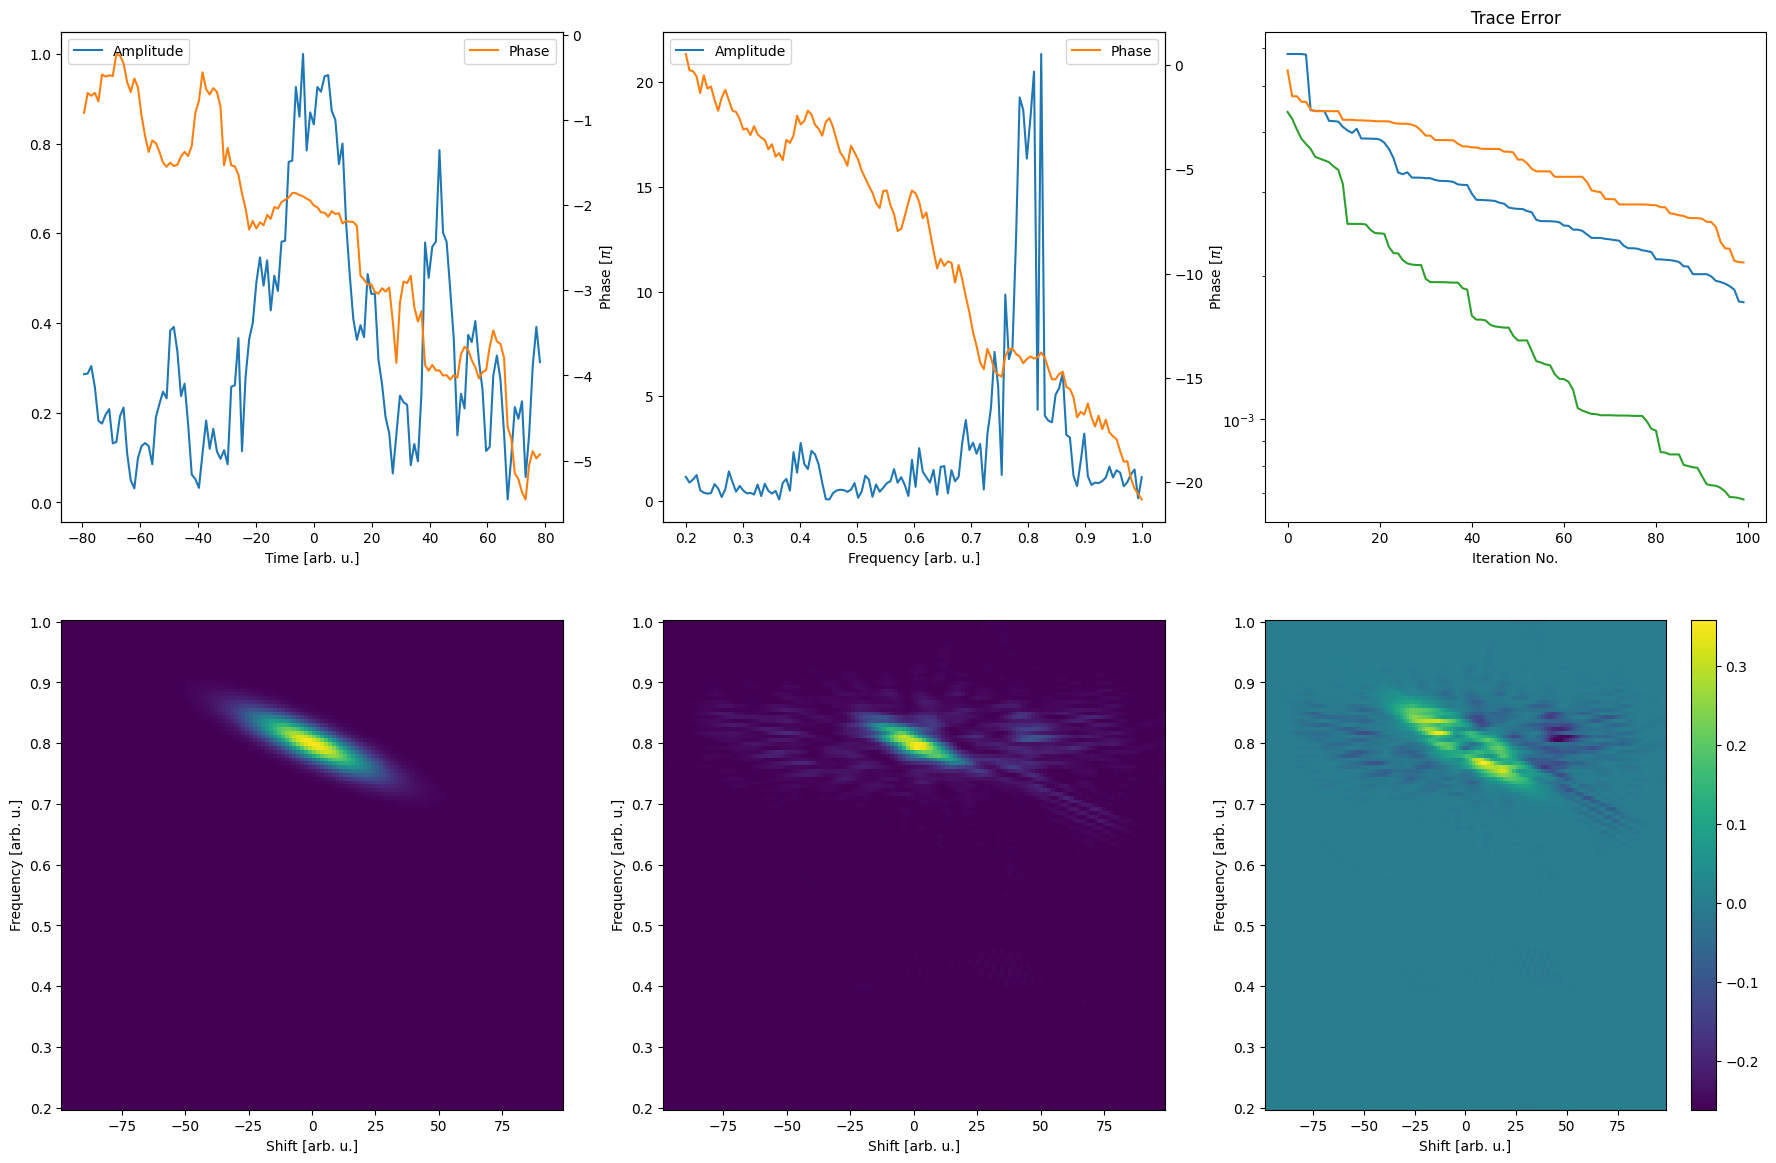

In [ ]:
# de = DifferentialEvolution(time, frequency, trace, "shg", xfrog="doubleblind")
# population = de.create_initial_population(population_size=50)

# final_result = de.run(population, 100)
# de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(time, frequency, trace, "shg", xfrog="doubleblind")
# evo.solver = CMA_ES
# population = evo.create_initial_population(population_size=250)

# final_result = evo.run(population, 100)
# evo.plot_results(final_result)




# lsf = LSF(time, frequency, trace, "shg", xfrog="doubleblind")
# population = lsf.create_initial_population(population_size=3, amp_type="discrete", phase_type="discrete")

# lsf.number_of_bisection_iterations=8
# lsf.random_direction_mode="continuous"
# lsf.no_points_for_continuous=15

# final_result = lsf.run(population, 100)
# lsf.plot_results(final_result)





# ad = AutoGrad(time, frequency, trace, "shg", xfrog="doubleblind")
# population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")


# final_result = ad.run(population, 1000)
# ad.plot_results(final_result)

In [ ]:
from general_algorithms_dscan import DifferentialEvolution, Evosax, LSF, AutoGrad

make functions for each type, wait until this subproject seems to be really finalized
population [0.99999994 0.99999994 0.99999994]
direction [1.        1.        1.0000001]
(Array([[-12.247329],
       [-10.494735],
       [ -8.516734]], dtype=float32), Array([[12.247329],
       [10.494735],
       [ 8.880508]], dtype=float32))
population [12.269873   5.268321   1.4937216]
direction [0.99999994 0.99999994 1.        ]
(Array([[-1.2669201],
       [-7.642658 ],
       [-5.058096 ]], dtype=float32), Array([[0.03313255],
       [8.016147  ],
       [5.396682  ]], dtype=float32))
population [12.50497    6.0722427  1.5048381]
direction [1. 1. 1.]
(Array([[ 0.       ],
       [-6.062381 ],
       [-7.7990026]], dtype=float32), Array([[1.1349912],
       [8.383532 ],
       [7.774252 ]], dtype=float32))
population [12.416049   6.8617043  1.5365317]
direction [1. 1. 1.]
(Array([[ -2.490117 ],
       [ -6.1801214],
       [-11.466432 ]], dtype=float32), Array([[7.6293945e-06],
       [7.260014

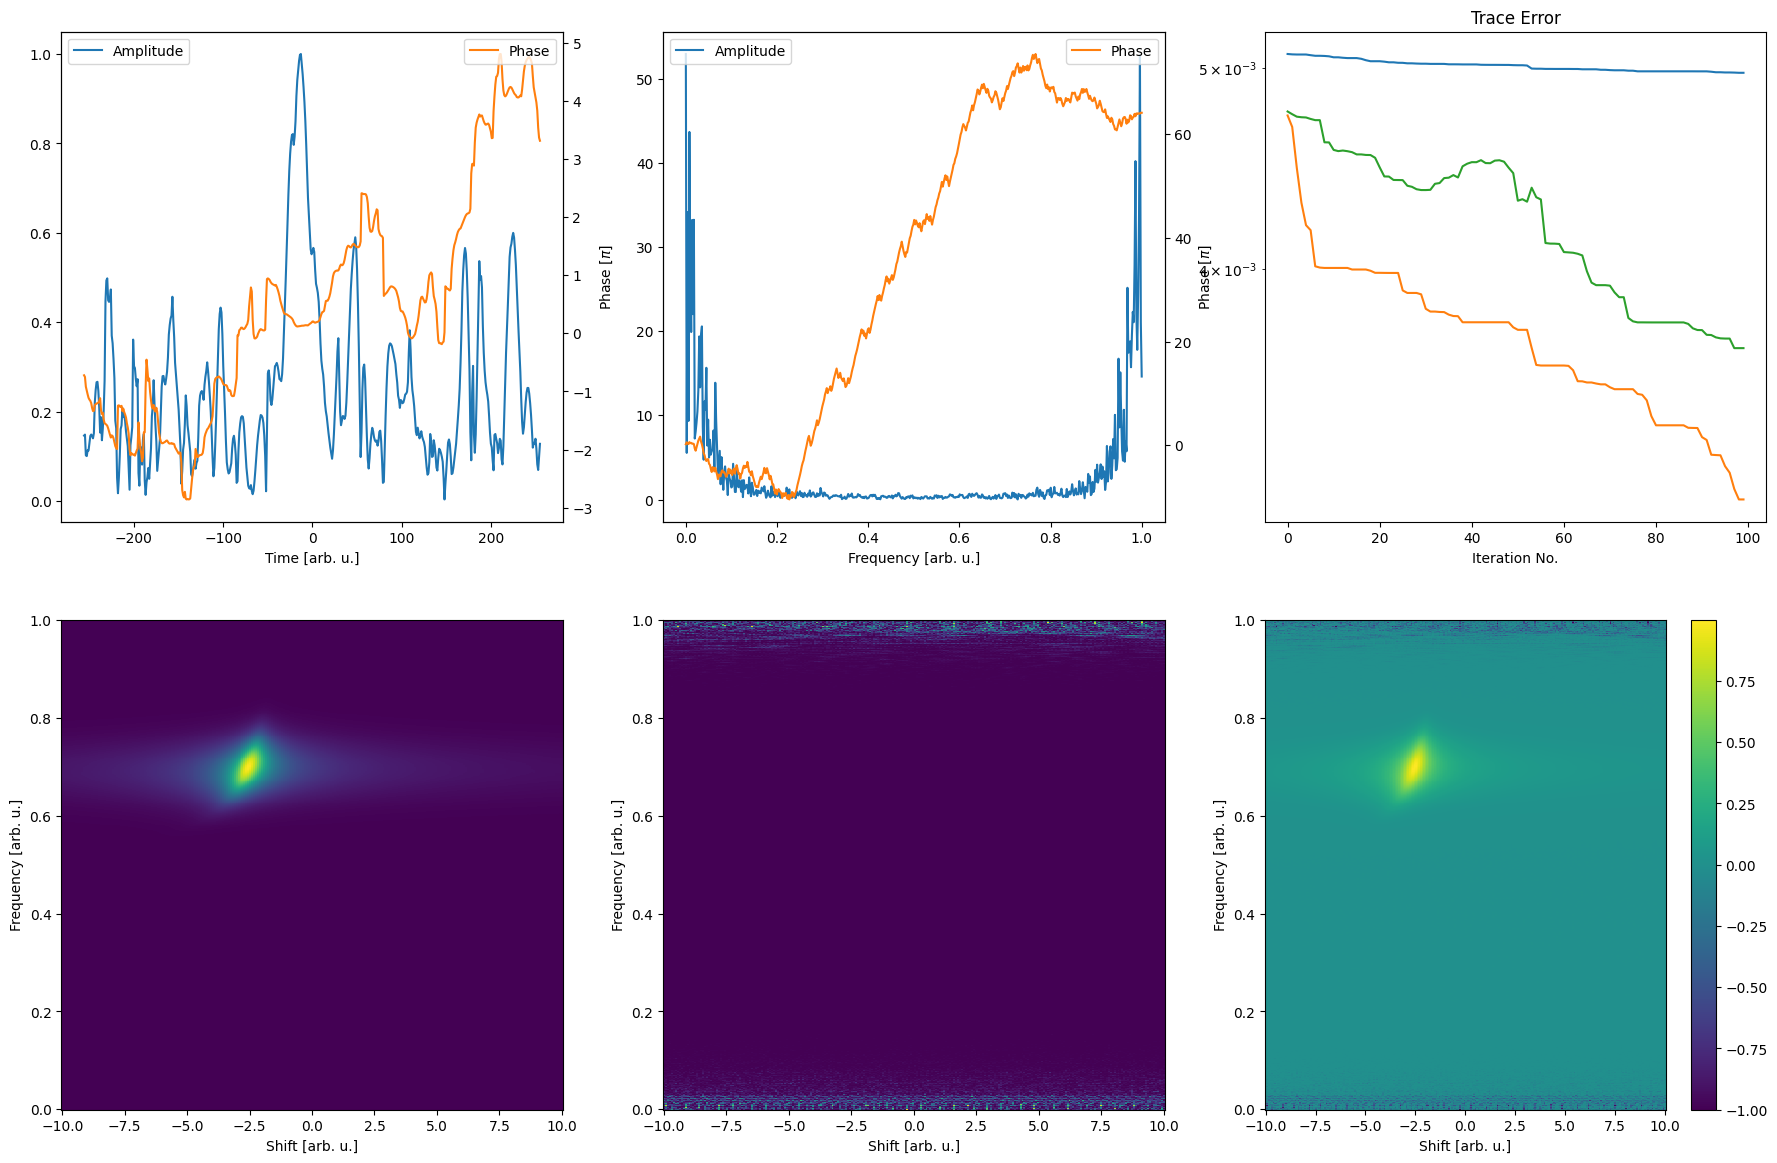

In [ ]:
# de = DifferentialEvolution(z_arr, frequency, trace, "shg")
# population = de.create_initial_population(population_size=150)

# final_result = de.run(population, 100)
# de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(z_arr, frequency, trace, "shg")
# evo.solver = CMA_ES
# population = evo.create_initial_population(population_size=250)

# final_result = evo.run(population, 100)
# evo.plot_results(final_result)




lsf = LSF(z_arr, frequency, trace, "shg")  # doesnt work and returns nans???
population = lsf.create_initial_population(population_size=3, amp_type="discrete", phase_type="discrete", no_funcs_amp=1)

lsf.number_of_bisection_iterations=12
lsf.random_direction_mode="continuous"
lsf.no_points_for_continuous=15

final_result = lsf.run(population, 100)
lsf.plot_results(final_result)





# ad = AutoGrad(z_arr, frequency, trace, "shg")
# population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")

# ad.solver=optax.adam(learning_rate=1e-1)

# final_result = ad.run(population, 1000)
# ad.plot_results(final_result)